In [1]:
import json
import glob
import ast

import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers.cross_encoder import CrossEncoder

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
df = pd.read_csv("data/dblp/author.csv")
df

,id,name,org
0,1898054021,Ioannis Delis,"Department of Biomedical Sciences, University ..."
1,2645550909,Pauline Hilt,"Fondazione Istituto Italiano di Tecnologia, Ce..."
2,531415370,Thierry Pozzo,"Fondazione Istituto Italiano di Tecnologia, Ce..."
3,322723101,Stefano Panzeri,"Neural Computation Laboratory, Center for Neur..."
4,79947125,Bastien Berret,"Univ. Paris-Sud, Université Paris-Saclay, Orsa..."
...,...,...,...
4398133,2962813519,Je-Kwang Ryu,NaN
4398134,2964296278,Boyuan Kong,Dept. of Electrical Engineering and Computer S...
4398135,2963126023,Fahem Kebair,NaN
4398136,2473832003,Asmaa H. Elsaid,"Information Systems Department, Faculty of Com..."


In [3]:
df_copy = df.copy()
df_copy = df_copy[:1000]
df_copy

,id,name,org
0,1898054021,Ioannis Delis,"Department of Biomedical Sciences, University ..."
1,2645550909,Pauline Hilt,"Fondazione Istituto Italiano di Tecnologia, Ce..."
2,531415370,Thierry Pozzo,"Fondazione Istituto Italiano di Tecnologia, Ce..."
3,322723101,Stefano Panzeri,"Neural Computation Laboratory, Center for Neur..."
4,79947125,Bastien Berret,"Univ. Paris-Sud, Université Paris-Saclay, Orsa..."
...,...,...,...
995,2903608352,Jiajun Zhuang,"College of Automation, Zhongkai University of ..."
996,2517837248,Shaoming Luo,"College of Automation, Zhongkai University of ..."
997,2766178101,Chaojun Hou,"College of Automation, Zhongkai University of ..."
998,2888051220,Yu Tang,"College of Automation, Zhongkai University of ..."


In [4]:
copy_records = df_copy.to_dict('records')
copy_records[0]

{'id': 1898054021,
 'name': 'Ioannis Delis',
 'org': 'Department of Biomedical Sciences, University of Leeds, Leeds, UK'}

In [5]:
from functools import lru_cache

class GenderClassifier(object):
    """
    Class to predict gender for a given name
    """
    def __init__(self, model_path):
        
        self.target_names = ["female", "male"]
        self.model = self.load_model(model_path)
        
    @lru_cache(maxsize=128)
    def load_model(self, model_path):
        """ Load CrossEncoder classifier
        
        :param model_path: CrossEncoder model path
        :return: classification model
        """
        model = CrossEncoder(
            model_path, 
            num_labels=len(self.target_names),
            device='cpu'
        )
        return model
        
    def predict(self, name):
        """
        Predict label
        
        :param name: input name
        :return: predicted label, confidence
        """
        prediction = dict()
        
        probs = self.model.predict(sentences=[name], apply_softmax=True)
        target_idx = probs.argmax(axis=0)
        confidence = probs[target_idx]
        gender = self.target_names[probs.argmax(axis=0)]
        
        prediction["gender"] = gender
        prediction["confidence"] = "{0:.4f}".format(confidence)
        return prediction

In [6]:
model_path = "models/gender_name_detection/202303090944"
model_path

'models/gender_name_detection/202303090944'

In [7]:
classifier = GenderClassifier(model_path)

In [8]:
classifier.predict("Anamaria Tamasan")

{'gender': 'female', 'confidence': '0.9856'}

In [9]:
def predict_func(name):
    """
    Predict gender for given
    name
    """
    pred = classifier.predict(name)
    gender = pred["gender"]
    confidence = pred["confidence"]
    return pd.Series([gender, confidence])

In [10]:
predict_func("Anamaria Tamasan")

0    female
1    0.9856
dtype: object

In [11]:
predict_func("Dacian Tamasan")

0      male
1    0.9165
dtype: object

In [12]:
df_copy[['gender', 'confidence']] = df_copy['name'].progress_apply(lambda x: predict_func(x))
df_copy

  0%|          | 0/1000 [00:00<?, ?it/s]

,id,name,org,gender,confidence
0,1898054021,Ioannis Delis,"Department of Biomedical Sciences, University ...",male,0.9823
1,2645550909,Pauline Hilt,"Fondazione Istituto Italiano di Tecnologia, Ce...",male,0.8822
2,531415370,Thierry Pozzo,"Fondazione Istituto Italiano di Tecnologia, Ce...",male,0.9869
3,322723101,Stefano Panzeri,"Neural Computation Laboratory, Center for Neur...",male,0.9862
4,79947125,Bastien Berret,"Univ. Paris-Sud, Université Paris-Saclay, Orsa...",male,0.8313
...,...,...,...,...,...
995,2903608352,Jiajun Zhuang,"College of Automation, Zhongkai University of ...",male,0.9114
996,2517837248,Shaoming Luo,"College of Automation, Zhongkai University of ...",male,0.6488
997,2766178101,Chaojun Hou,"College of Automation, Zhongkai University of ...",male,0.8608
998,2888051220,Yu Tang,"College of Automation, Zhongkai University of ...",male,0.6806


In [13]:
df_copy['gender'].value_counts()

male      763
female    237
Name: gender, dtype: int64

In [14]:
copy_records[:5]

[{'id': 1898054021,
  'name': 'Ioannis Delis',
  'org': 'Department of Biomedical Sciences, University of Leeds, Leeds, UK'},
 {'id': 2645550909,
  'name': 'Pauline Hilt',
  'org': 'Fondazione Istituto Italiano di Tecnologia, Centro di Neurofisiologia traslazionale c/o sezione Fisiologia Umana, Ferrara, Italy'},
 {'id': 531415370,
  'name': 'Thierry Pozzo',
  'org': 'Fondazione Istituto Italiano di Tecnologia, Centro di Neurofisiologia traslazionale c/o sezione Fisiologia Umana, Ferrara, Italy'},
 {'id': 322723101,
  'name': 'Stefano Panzeri',
  'org': 'Neural Computation Laboratory, Center for Neuroscience and Cognitive Systems@UniTn, Istituto Italiano di Tecnologia, Rovereto (TN), Italy'},
 {'id': 79947125,
  'name': 'Bastien Berret',
  'org': 'Univ. Paris-Sud, Université Paris-Saclay, Orsay Cedex, France'}]

In [15]:
len(copy_records)

1000

In [16]:
df

,id,name,org
0,1898054021,Ioannis Delis,"Department of Biomedical Sciences, University ..."
1,2645550909,Pauline Hilt,"Fondazione Istituto Italiano di Tecnologia, Ce..."
2,531415370,Thierry Pozzo,"Fondazione Istituto Italiano di Tecnologia, Ce..."
3,322723101,Stefano Panzeri,"Neural Computation Laboratory, Center for Neur..."
4,79947125,Bastien Berret,"Univ. Paris-Sud, Université Paris-Saclay, Orsa..."
...,...,...,...
4398133,2962813519,Je-Kwang Ryu,NaN
4398134,2964296278,Boyuan Kong,Dept. of Electrical Engineering and Computer S...
4398135,2963126023,Fahem Kebair,NaN
4398136,2473832003,Asmaa H. Elsaid,"Information Systems Department, Faculty of Com..."


In [17]:
df[['gender', 'confidence']] = df['name'].progress_apply(lambda x: predict_func(x))
df

  0%|          | 0/4398138 [00:00<?, ?it/s]

,id,name,org,gender,confidence
0,1898054021,Ioannis Delis,"Department of Biomedical Sciences, University ...",male,0.9823
1,2645550909,Pauline Hilt,"Fondazione Istituto Italiano di Tecnologia, Ce...",male,0.8822
2,531415370,Thierry Pozzo,"Fondazione Istituto Italiano di Tecnologia, Ce...",male,0.9869
3,322723101,Stefano Panzeri,"Neural Computation Laboratory, Center for Neur...",male,0.9862
4,79947125,Bastien Berret,"Univ. Paris-Sud, Université Paris-Saclay, Orsa...",male,0.8313
...,...,...,...,...,...
4398133,2962813519,Je-Kwang Ryu,NaN,male,0.9778
4398134,2964296278,Boyuan Kong,Dept. of Electrical Engineering and Computer S...,male,0.9575
4398135,2963126023,Fahem Kebair,NaN,male,0.9441
4398136,2473832003,Asmaa H. Elsaid,"Information Systems Department, Faculty of Com...",female,0.9148


In [19]:
df.to_csv('data/dblp/author_gender.csv', index=False)

In [20]:
df["gender"].value_counts()

male      3306401
female    1091737
Name: gender, dtype: int64

Total gender counts =  3306401


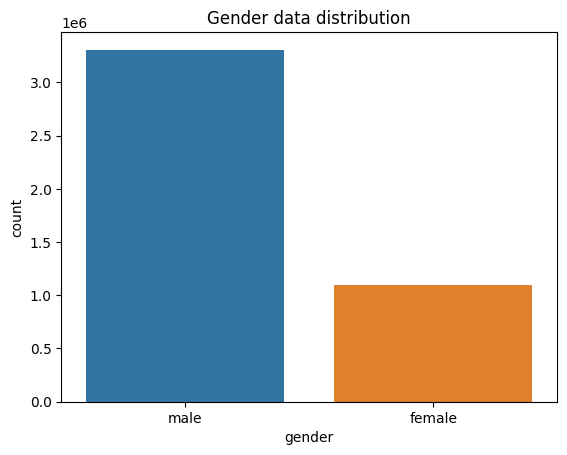

In [21]:
df['gender'].value_counts()
print("Total gender counts = ", df['gender'].value_counts()[0])
ax = sns.countplot(x=df['gender']).set(title='Gender data distribution')